<a href="https://colab.research.google.com/github/ankile/MIT6.036-Intro-Machine-Learning/blob/master/hw-02/MIT_6_036_HW02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MIT 6.036 Spring 2020: Homework 2#

This colab notebook provides code and a framework for problems 8-10 of the homework.  You can work out your solutions here, then submit your results back on the homework page when ready.

## <section>**Setup**</section>

First, download the code distribution for this homework that contains test cases and helper functions (such as `positive`).

Run the next code block to download and import the code for this lab.


In [2]:
!rm -f code_for_hw02.py*
!wget --quiet https://introml.odl.mit.edu/cat-soop/_static/6.036/homework/hw02/code_for_hw02.py
from code_for_hw02 import *
import numpy as np

Importing code_for_hw02
New procedures added: tidy_plot, plot_separator, plot_data, plot_nonlin_sep, cv,
                      rv, positive, score
Data Sets: super_simple_separable_through_origin(), super_simple_separable(), xor(),
           xor_more()
Test data for problem 2.1: data1, labels1, data2, labels2
Test data for problem 2.2: big_data, big_data_labels, gen_big_data(), gen_lin_separable(),
                           big_higher_dim_separable(), gen_flipped_lin_separable()
Test functions: test_linear_classifier(), test_perceptron(), test_averaged_perceptron(),
                test_eval_classifier(), test_eval_learning_alg(), test_xval_learning_alg()

For more information, use 'help', e.g. 'help tidy_plot'
Done with import of code_for_hw02


# 8) Implement Perceptron

Implement [the Perceptron algorithm](https://lms.mitx.mit.edu/courses/course-v1:MITx+6.036+2020_Spring/courseware/Week2/perceptron/2), where

* `data` is a numpy array of dimension $d$ by $n$
* `labels` is numpy array of dimension $1$ by $n$
* `params` is a dictionary specifying extra parameters to this algorithm; your algorithm should run a number of iterations equal to $T$
* `hook` is either `None` or a function that takes the tuple `(th, th0)` as an argument and displays the separator graphically.  We won't be testing this in the Tutor, but it will help you in debugging on your own machine.

It should return a tuple of $\theta$ (a $d$ by 1 array) and $\theta_0$ (a 1 by 1 array).

We have given you some  data sets in the code file for you to test your implementation. Below are some test cases.
```
# Test Case 1
>>> data = np.array([[2, 3, 9, 12],
                     [5, 2, 6, 5]])
>>> labels = np.array([[1, -1, 1, -1]])
>>> [x.tolist() for x in perceptron(data, labels, {"T": 100})]
[[[-24.0], [37.0]], [[-3.0]]]

# Test Case 2
>>> data = np.array([[1, 2, 1, 2],
                     [1, 2, 2, 1]])
>>> labels = np.array([[1, 1, -1, -1]])
>>> [x.tolist() for x in perceptron(data, labels, {"T": 100})]
[[[0.0], [-3.0]], [[0.0]]]
```

Your function should initialize any parameters defined in the function to 0, then run through the data, in the order it is given, performing an update to the parameters whenever the current parameters would make a mistake on that data point. Perform `T` iterations through the data. After every parameter update, if `hook` is defined, call it on the current `(th, th0)` (as a single parameter in a Python tuple).

In [0]:
def perceptron(data, labels, params={}, hook=None):
    d, n = data.shape

    # if T not in params, default to 100
    T = params.get('T', 100)
    th = params.get('th', np.zeros((d,1)))
    th0 = params.get('th0', np.array([[0]]))

    data_list = np.array([data.T]).reshape((n, d, 1))
    label_list = labels.reshape((n))

    for t in range (T):
      for x, y in zip(data_list, label_list):
        if y * (np.dot(th.T, x) + th0) <= 0:
          # Update the thetas
          th = th + y * x
          th0 = th0 + y

          if hook is not None:
            hook((th, th0))

    return th, th0

[[[-4.0], [19.0], [-16.0]], [[4]]]

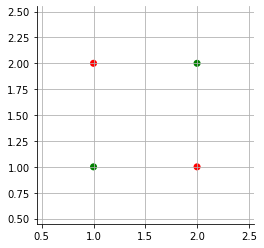

In [4]:
# Manual test of the perceptron

# Test Case 2
data = np.array([[1, 2, 1, 2],
                 [1, 2, 2, 1],
                 [1, 2, 3, 1]])
labels = np.array([[1, 1, -1, -1]])
ax = plot_data(data, labels)
[x.tolist() for x in perceptron(data, labels, params={"T": 100})]


In [5]:
# Manual test of perceptron for big data
[x.tolist() for x in perceptron(big_data, big_data_labels, params={"T": 100})]

[[[2.0594504499999635], [2.6697753999999927]], [[-1.0]]]

In [0]:
test_perceptron(perceptron)

Data: [[ 2  3  9 12]
 [ 5  1  6  5]]
Labels: [[ 1 -1  1 -1]]
-----------Test Perceptron 0-----------
Passed! 

Data: [[1 2 1 2]
 [1 2 2 1]]
Labels: [[ 1  1 -1 -1]]
-----------Test Perceptron 1-----------
Passed! 



# 9) Implement Averaged Perceptron

Regular perceptron can be somewhat sensitive to the most recent examples that it sees. Instead, averaged perceptron produces a more stable output by outputting the average value of `th` and `th0` across all iterations.

Below are some test cases.
```
# Test Case 1
>>> data = np.array([[2, 3, 9, 12],
                     [5, 2, 6, 5]])
>>> labels = np.array([[1, -1, 1, -1]])
>>> [x.tolist() for x in averaged_perceptron(data, labels, {"T": 100})]
[[[-22.1925], [34.06]], [[-2.1725]]]

# Test Case 2
>>> data = np.array([[1, 2, 1, 2],
                     [1, 2, 2, 1]])
>>> labels = np.array([[1, 1, -1, -1]])
>>> [x.tolist() for x in averaged_perceptron(data, labels, {"T": 100})]
[[[1.47], [-1.7275]], [[0.985]]]
```


Implement averaged perceptron with the same spec as regular perceptron, and using the pseudocode below as a guide.

<pre>
procedure averaged_perceptron({(x^(i), y^(i)), i=1,...n}, T)
    th = 0 (d by 1); th0 = 0 (1 by 1)
    ths = 0 (d by 1); th0s = 0 (1 by 1)
    for t = 1,...,T do:
        for i = 1,...,n do:
	        if y^(i)(th . x^(i) + th0) <= 0 then
              th = th + y^(i)x^(i)
              th0 = th0 + y^(i)
	        ths = ths + th
	        th0s = th0s + th0
    return ths/(nT), th0s/(nT)
</pre>

In [0]:
def averaged_perceptron(data, labels, params={}, hook=None):
    d, n = data.shape

    # if T not in params, default to 100
    T = params.get('T', 100)
    th = params.get('th', np.zeros((d,1)))
    th0 = params.get('th0', np.array([[0]]))
    ths = np.zeros((d,1))
    th0s = np.zeros((1, 1))

    data_list = np.array([data.T]).reshape((n, d, 1))
    label_list = labels.reshape((n))

    for t in range (T):
        for x, y in zip(data_list, label_list):
            if y * (np.dot(th.T, x) + th0) <= 0:
                # Update the thetas
                th = th + y * x
                th0 = th0 + y

            if hook is not None:
                hook((th, th0))

            ths += th
            th0s += th0

    return ths / (n*T), th0s / (n*T)

In [10]:
test_averaged_perceptron(averaged_perceptron)

-----------Test Averaged Perceptron 0-----------
Passed! 

-----------Test Averaged Perceptron 1-----------
Passed! 



# 10) Implement Evaluation Strategies
  
## 10.1)  Evaluating a Classifier

To evaluate a classifier, we are interested in how well it performs on data that it wasn't trained on. Construct a testing procedure that uses a training data set, calls a learning algorithm to get a linear separator (a tuple of $\theta, \theta_0$), and then reports the percentage correct on a new testing set as a float between $0.0$ and $1.0$.

The learning algorithm is passed as a function that takes a data array and a labels vector.  Your evaluator should be able to interchangeably evaluate `perceptron` or `averaged_perceptron` (or future algorithms with the same spec), depending on what is passed through the `learner` parameter.

Assume that you have available the function `score` from HW 1, which takes inputs:

* `data`: a `d` by `n` array of floats (representing `n` data points in `d` dimensions)
* `labels`: a `1` by `n` array of elements in `(+1, -1)`, representing target labels
* `th`: a `d` by `1` array of floats that together with `th0`, represents a hyperplane
* `th0`: a single scalar or `1` by `1` array

and returns a scalar number of data points that the separator correctly classified.

The `eval_classifier` function should accept the following parameters:

* `learner` - a function, such as `perceptron` or `averaged_perceptron`
* `data_train` - training data
* `labels_train` - training labels
* `data_test` - test data
* `labels_test` - test labels

and returns the percentage correct on a new testing set as a float between $0.0$ and $1.0$.


In [0]:
# The function Score from HW 1
def score(data, labels, th, th0):
    return np.sum(positive(data, th, th0) == labels)

In [0]:
def eval_classifier(learner, data_train, labels_train, data_test, labels_test):
    _, n = data_test.shape
    
    th, th0 = learner(data_train, labels_train)

    return score(data_test, labels_test, th, th0) / n

In [23]:
test_eval_classifier(eval_classifier, perceptron)

-----------Test Eval Classifier 0-----------
Passed! 

-----------Test Eval Classifier 1-----------
Passed! 



## 10.2) Evaluating a Learning algorithm using a data source

Construct a testing procedure that takes a learning algorithm and a data source as input and runs the learning algorithm multiple times, each time evaluating the resulting classifier as above. It should report the overall average classification accuracy.

You can use our implementation of `eval_classifier` as above.

Write the function `eval_learning_alg` that takes:

* `learner` - a function, such as `perceptron` or `averaged_perceptron`
* `data_gen` - a data generator, call it with a desired data set size; returns a tuple `(data, labels)`
* `n_train` - the size of the learning sets
* `n_test` - the size of the test sets
* `it` - the number of iterations to average over

and returns the average classification accuracy as a float between $0.0$ and $1.0$.

**Note: Be sure to generate your training data and then testing data in that order, to ensure that the pseudo-randomly generated data matches that in the test code.**

In [0]:
def eval_learning_alg(learner, data_gen, n_train, n_test, it, test_data=True):
    score_sum = 0
    for _ in range(it):
        data_train, labels_train = data_gen(n_train)
        if test_data:
            data_test, labels_test = data_gen(n_test)
        else:
            data_test, labels_test = data_train, labels_train
        
        score_sum += eval_classifier(learner, data_train, labels_train, data_test, labels_test)
    
    return score_sum / it

In [25]:
test_eval_learning_alg(eval_learning_alg, perceptron)

-----------Test Eval Learning Algo-----------
Passed! 



## 10.3) Evaluating a Learning Algorithm With a Fixed Dataset

Cross-validation is a strategy for evaluating a learning algorithm, using a single training set of size $n$. Cross-validation takes in a learning algorithm $L$, a fixed data set $\mathcal{D}$, and a parameter $k$. It will run the learning algorithm $k$ different times, then evaluate the accuracy of the resulting classifier, and ultimately return the average of the accuracies over each of the $k$ "runs" of $L$. It is structured like this:

<pre><code>divide D into k parts, as equally as possible;  call them D_i for i == 0 .. k-1
# be sure the data is shuffled in case someone put all the positive examples first in the data!
for j from 0 to k-1:
    D_minus_j = union of all the datasets D_i, except for D_j
    h_j = L(D_minus_j)
    score_j = accuracy of h_j measured on D_j
return average(score0, ..., score(k-1))</code></pre>

So, each time, it trains on  $k−1$ of the pieces of the data set and tests the resulting hypothesis on the piece that was not used for training.

When $k=n$, it is called *leave-one-out cross validation*.

Implement cross validation **assuming that the input data is shuffled already** so that the positives and negatives are distributed randomly. If the size of the data does not evenly divide by k, split the data into `n % k` sub-arrays of size `n // k + 1` and the rest of size `n // k`. (Hint: You can use <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.array_split.html">np.array_split</a>
and <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.concatenate.html">np.concatenate</a> with axis arguments to split and rejoin the data as you desire.)

Note: In Python, `n//k` indicates integer division, e.g. `2//3 = 0` and `4//3 = 1`.

In [0]:
def xval_learning_alg(learner, data, labels, k):
    data_parts = np.array_split(data, k, axis=1)
    label_parts = np.array_split(labels, k, axis=1)

    k_sum = 0
    for i in range(k):
        data_train = np.concatenate((*data_parts[0:i], *data_parts[i+1:]), axis=1)
        labels_train = np.concatenate((*label_parts[0:i], *label_parts[i+1:]), axis=1)
        data_test = data_parts[i]
        labels_test = label_parts[i]
        k_sum += eval_classifier(learner, data_train, labels_train, data_test, labels_test)

    return k_sum / k

In [73]:
test_xval_learning_alg(xval_learning_alg, perceptron)

-----------Test Cross-eval Learning Algo-----------
Passed! 



## 11) Testing

In this section, we compare the effectiveness of perceptron and averaged perceptron on some data that are not necessarily linearly separable.

Use your `eval_learning_alg` and the `gen_flipped_lin_separable`
function in the code file to evaluate the accuracy of `perceptron`
vs. `averaged_perceptron`.  `gen_flipped_lin_separable` is a wrapper
function that returns a generator - `flip_generator`, which can be
called with an integer to return a data set and labels.  Note that this
generates linearly separable data and then "flips" the labels with
some specified probability (the argument `pflip`); so most of the
results will not be linearly separable.  You can also **specifiy** `pflip`
in the call to the generator wrapper function. At the
bottom of the code distribution is an example.

Run enough trials so that you can confidently predict the accuracy of
these algorithms on new data from that same generator; assume
training/test sets on the order of 20 points.  The Tutor will check
that your answer is within `0.025` of the answer we got using the same
generator.

In [66]:
# Example
data_gen = gen_flipped_lin_separable(pflip=0.5)
print(eval_learning_alg(perceptron, data_gen, n_train=20, n_test=20, it=5))

0.4800000000000001


### Test of perceptron with test data

In [67]:
# Accuracy for Perceptron (with flip probability 0.1)
generator1 = gen_flipped_lin_separable(pflip=0.1)
eval_learning_alg(perceptron, generator1, n_train=20, n_test=20, it=100)

0.7489999999999999

In [68]:
# Accuracy for averaged Perceptron (with flip probability 0.1)
eval_learning_alg(averaged_perceptron, generator1, n_train=20, n_test=20, it=100)

0.7794999999999999

In [69]:
# Accuracy for Perceptron (with flip probability 0.25)
generator2 = gen_flipped_lin_separable(pflip=0.25)
eval_learning_alg(perceptron, generator2, n_train=20, n_test=20, it=100)

0.6075000000000002

In [70]:
# Accuracy for averaged Perceptron (with flip probability 0.25)
eval_learning_alg(averaged_perceptron, generator2, n_train=20, n_test=20, it=100)

0.6445000000000002

### Test of perceptron with training data

In [74]:
# Accuracy for Perceptron (with flip probability 0.1) on training data
generator1 = gen_flipped_lin_separable(pflip=0.1)
eval_learning_alg(perceptron, generator1, n_train=20, n_test=20, it=100, test_data=False)

0.8390000000000002

In [75]:
# Accuracy for averaged Perceptron (with flip probability 0.1) on training data
eval_learning_alg(averaged_perceptron, generator1, n_train=20, n_test=20, it=100, test_data=False)

0.8680000000000001

In [76]:
# Accuracy for Perceptron (with flip probability 0.25) on training data
generator2 = gen_flipped_lin_separable(pflip=0.25)
eval_learning_alg(perceptron, generator2, n_train=20, n_test=20, it=100, test_data=False)

0.6629999999999999

In [77]:
# Accuracy for averaged Perceptron (with flip probability 0.25) on training data
eval_learning_alg(averaged_perceptron, generator2, n_train=20, n_test=20, it=100, test_data=False)

0.7020000000000001